In [285]:
# the training become much better when increase the epoc and early stopping patience
# window size larger, can forcast eariler
# window size smaller, can forcast the results later

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np

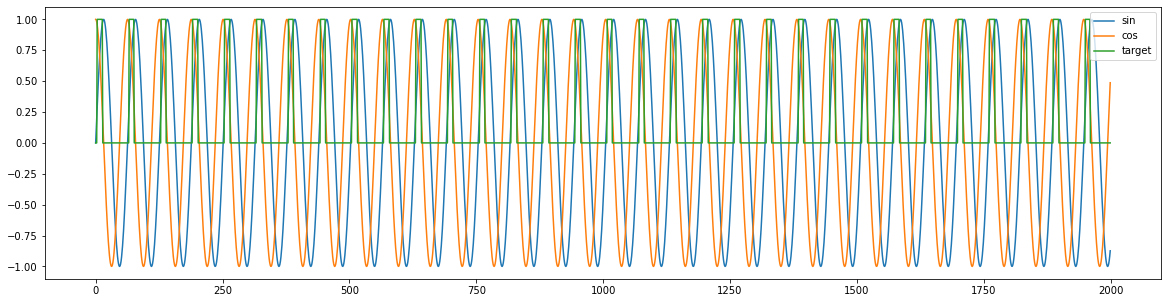

In [286]:
def f(row):
    if row["sin"]>0.25 and row["cos"]>=0.25:
        return 1
    else:
        return 0

x1 = np.sin(np.linspace(0,200,2000))
x2 = np.cos(np.linspace(0,200,2000))
df = pd.DataFrame({"sin": x1, "cos":x2})
df["target"] = df.apply(f, axis=1)

df.head()
df.plot(y=["sin","cos","target"], figsize=(20, 5))

In [287]:
correlation_df = df.corr()
print(correlation_df)

             sin       cos    target
sin     1.000000  0.003605  0.426696
cos     0.003605  1.000000  0.436207
target  0.426696  0.436207  1.000000


In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sin     2000 non-null   float64
 1   cos     2000 non-null   float64
 2   target  2000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 47.0 KB


### Test and Train Split

In [289]:
test_ind = len(df)//10

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

### Scale Data

In [290]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


### Time Series

In [291]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 90
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

len(generator)
print(generator[0])

(array([[[5.00000243e-01, 1.00000000e+00, 0.00000000e+00],
        [5.49943812e-01, 9.97499585e-01, 0.00000000e+00],
        [5.99387863e-01, 9.90023348e-01, 0.00000000e+00],
        [6.47837873e-01, 9.77646064e-01, 1.00000000e+00],
        [6.94809260e-01, 9.60491526e-01, 1.00000000e+00],
        [7.39832234e-01, 9.38731309e-01, 1.00000000e+00],
        [7.82456490e-01, 9.12583050e-01, 1.00000000e+00],
        [8.22255715e-01, 8.82308275e-01, 1.00000000e+00],
        [8.58831850e-01, 8.48209783e-01, 1.00000000e+00],
        [8.91819073e-01, 8.10628615e-01, 1.00000000e+00],
        [9.20887457e-01, 7.69940645e-01, 1.00000000e+00],
        [9.45746270e-01, 7.26552821e-01, 1.00000000e+00],
        [9.66146883e-01, 6.80899092e-01, 1.00000000e+00],
        [9.81885256e-01, 6.33436072e-01, 1.00000000e+00],
        [9.92803978e-01, 5.84638469e-01, 0.00000000e+00],
        [9.98793845e-01, 5.34994342e-01, 0.00000000e+00],
        [9.99794948e-01, 4.85000213e-01, 0.00000000e+00],
        [9.95

### Create the Model

In [292]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

scaled_train.shape

(1800, 3)

In [293]:
model = Sequential()
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________


### Early Stopping

In [294]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)
model.fit_generator(generator,epochs=50,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/50
1710/1710 [==============================] - 52s 30ms/step - loss: 0.0146 - val_loss: 0.0121
Epoch 2/50
1710/1710 [==============================] - 50s 29ms/step - loss: 0.0092 - val_loss: 0.0062
Epoch 3/50
1710/1710 [==============================] - 53s 31ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 4/50
1710/1710 [==============================] - 52s 31ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 5/50
1710/1710 [==============================] - 53s 31ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 6/50
1710/1710 [==============================] - 57s 34ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 7/50
1710/1710 [==============================] - 59s 35ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 8/50
1710/1710 [==============================] - 53s 31ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 9/50
1710/1710 [==============================] - 51s 30ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 10/50
1710/1710 [==============================] - 49s 29m

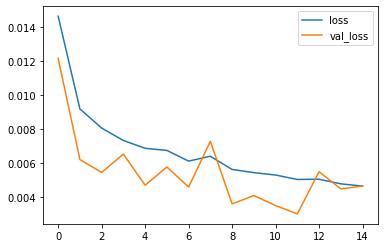

In [295]:
model.history.history.keys()
losses = pd.DataFrame(model.history.history)
losses.plot()

### Evaluate the Data

In [296]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))
p = model.predict(first_eval_batch)
print(p[0])
print(scaled_test[0])

[ 0.06467442  0.23645565 -0.00811069]
[0.07412218 0.23800342 0.        ]


In [297]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [298]:
test_predictions

[array([ 0.06467442,  0.23645565, -0.00811069], dtype=float32),
 array([ 0.03495246,  0.2767131 , -0.00970174], dtype=float32),
 array([ 0.00929029,  0.32044038, -0.0095961 ], dtype=float32),
 array([-0.01154447,  0.3678989 , -0.00809191], dtype=float32),
 array([-0.02670085,  0.4189074 , -0.00538073], dtype=float32),
 array([-0.03511351,  0.47301346, -0.00179504], dtype=float32),
 array([-0.03553441,  0.5293875 ,  0.00219697], dtype=float32),
 array([-0.02670303,  0.5867856 ,  0.00610443], dtype=float32),
 array([-0.00764984,  0.64363474,  0.00959024], dtype=float32),
 array([0.02194169, 0.69821393, 0.01259893], dtype=float32),
 array([0.06145403, 0.74887186, 0.01531791], dtype=float32),
 array([0.10928863, 0.7942207 , 0.01799675], dtype=float32),
 array([0.16314924, 0.833311  , 0.02086932], dtype=float32),
 array([0.22064435, 0.86582917, 0.02443482], dtype=float32),
 array([0.28004542, 0.89233637, 0.02993131], dtype=float32),
 array([0.34090057, 0.9144217 , 0.03925822], dtype=float32

In [299]:
scaled_test

array([[ 7.41221784e-02,  2.38003418e-01,  0.00000000e+00],
       [ 5.00818336e-02,  2.81849998e-01,  0.00000000e+00],
       [ 3.05414199e-02,  3.27878441e-01,  0.00000000e+00],
       [ 1.56963739e-02,  3.75628384e-01,  0.00000000e+00],
       [ 5.69517059e-03,  4.24622250e-01,  0.00000000e+00],
       [ 6.37838714e-04,  4.74370019e-01,  0.00000000e+00],
       [ 5.74959961e-04,  5.24374130e-01,  0.00000000e+00],
       [ 5.50716322e-03,  5.74134459e-01,  0.00000000e+00],
       [ 1.53851183e-02,  6.23153321e-01,  0.00000000e+00],
       [ 3.01100292e-02,  6.70940445e-01,  0.00000000e+00],
       [ 4.95346223e-02,  7.17017881e-01,  0.00000000e+00],
       [ 7.34646196e-02,  7.60924777e-01,  0.00000000e+00],
       [ 1.01660681e-01,  8.02221993e-01,  0.00000000e+00],
       [ 1.33840800e-01,  8.40496487e-01,  0.00000000e+00],
       [ 1.69683121e-01,  8.75365450e-01,  0.00000000e+00],
       [ 2.08829162e-01,  9.06480136e-01,  0.00000000e+00],
       [ 2.50887396e-01,  9.33529346e-01

### Inverse the Transform and Compare

In [300]:
true_predictions = scaler.inverse_transform(test_predictions)

In [301]:
compare_data = pd.DataFrame({"sin":test["sin"], "predict_sin":true_predictions[:,0], "cos":test["cos"], "predict_cos":true_predictions[:,1], "target":test["target"], "predict_target":true_predictions[:,2]})
compare_data.head(5)

,sin,predict_sin,cos,predict_cos,target,predict_target
1800,-0.851722,-0.870617,-0.523993,-0.527089,0,-0.008111
1801,-0.899801,-0.930059,-0.436300,-0.446574,0,-0.009702
1802,-0.938881,-0.981381,-0.344243,-0.359119,0,-0.009596
1803,-0.968569,-1.023049,-0.248743,-0.264202,0,-0.008092
1804,-0.988571,-1.053361,-0.150755,-0.162185,0,-0.005381


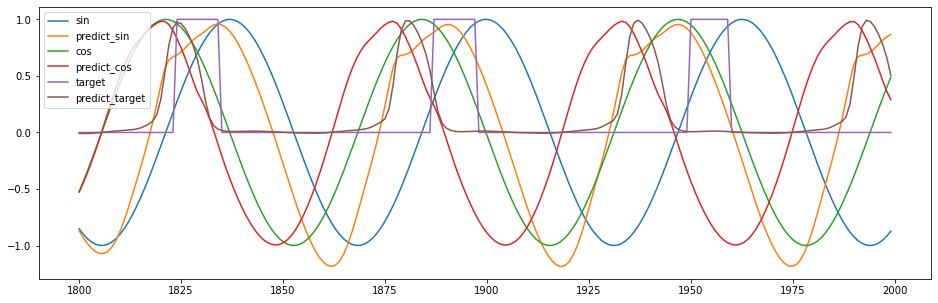

In [302]:
compare_data.plot(figsize=(16, 5))

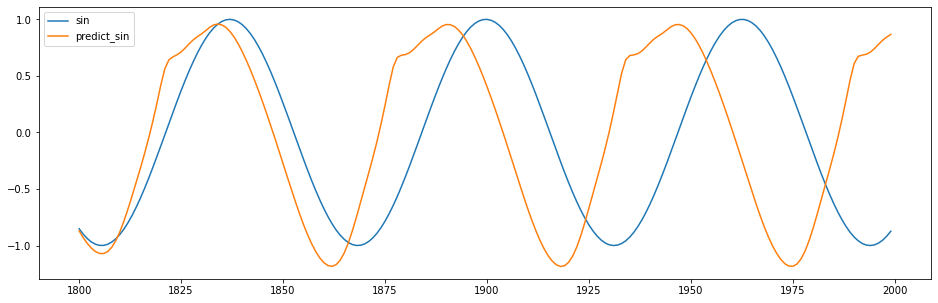

In [303]:
compare_data1 = pd.DataFrame({"sin":test["sin"], "predict_sin":true_predictions[:,0]})
compare_data1.plot(figsize=(16,5))


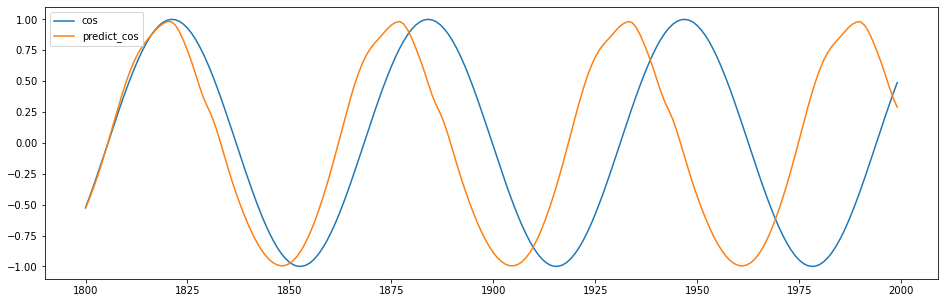

In [304]:
compare_data2 = pd.DataFrame({"cos":test["cos"], "predict_cos":true_predictions[:,1]})
compare_data2.plot(figsize=(16,5))


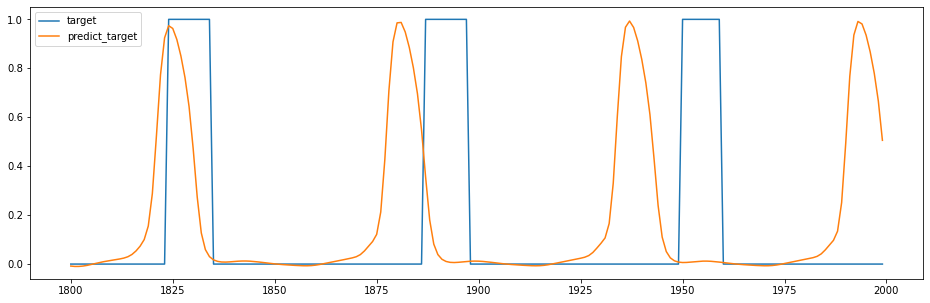

In [305]:
compare_data3 = pd.DataFrame({"target":test["target"], "predict_target":true_predictions[:,2]})
compare_data3.plot(figsize=(16,5))
